# Data Preprocessing

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load dataset
data_train = pd.read_csv('/Data/Visual Studio Code/Data Science/Dataset/UNSW-NB15/UNSW_NB15_training-set.csv')
data_test = pd.read_csv('/Data/Visual Studio Code/Data Science/Dataset/UNSW-NB15/UNSW_NB15_testing-set.csv')

In [5]:
# Handle missing value and duplicate if any
data_train.dropna(inplace=True)
data_train.drop_duplicates(inplace=True)

data_test.dropna(inplace=True)
data_test.drop_duplicates(inplace=True)

In [41]:
#Split Attack and Normal from dataframe
data_train_attack = data_train[data_train['label'] == 1]
data_test_attack = data_test[data_test['label'] == 1]

#Optional
#data_train_normal = data_train[data_train['label'] == 0]
#data_test_normal = data_test[data_test['label'] == 0]

In [42]:
# Drop id and label from train and test data
data_train_attack = data_train_attack.drop('id', axis=1)
data_train_attack = data_train_attack.drop('label', axis=1)

data_test_attack = data_test_attack.drop('id', axis=1)
data_test_attack = data_test_attack.drop('label', axis=1)

In [43]:
print(data_train_attack['state'].nunique())
print(data_test_attack['state'].nunique())

6
5


In [44]:
print(data_train_attack['state'].unique())
print(data_test_attack['state'].unique())

['INT' 'FIN' 'ACC' 'CON' 'REQ' 'CLO']
['INT' 'FIN' 'CON' 'REQ' 'RST']


In [45]:
#Drop ACC, CLO, and RST from data
data_train_attack = data_train_attack[(data_train_attack['state'] != 'ACC') & (data_train_attack['state'] != 'CLO')]
data_test_attack = data_test_attack[(data_test_attack['state'] != 'RST')]

In [46]:
print(data_train_attack['state'].unique())
print(data_test_attack['state'].unique())

['INT' 'FIN' 'CON' 'REQ']
['INT' 'FIN' 'CON' 'REQ']


## Encode Train and Test Data

In [47]:
#column to encode
cols = ['proto','state','service']
cols

['proto', 'state', 'service']

In [48]:
#One-hot Encoding
# Encode train data
data_train_attack = pd.get_dummies(data_train_attack, columns=cols)

# Encode test data
data_test_attack = pd.get_dummies(data_test_attack, columns=cols)

In [49]:
train_attack_cat = data_train_attack.pop('attack_cat')
test_attack_cat = data_test_attack.pop('attack_cat')

## Normalization

In [50]:
# Min-Max Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols_to_norm = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 
                'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 
                'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 
                'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 
                'ct_srv_dst', 'is_sm_ips_ports']

data_train_attack[cols_to_norm] = scaler.fit_transform(data_train_attack[cols_to_norm])
data_test_attack[cols_to_norm] = scaler.fit_transform(data_test_attack[cols_to_norm])

## Feature Selection

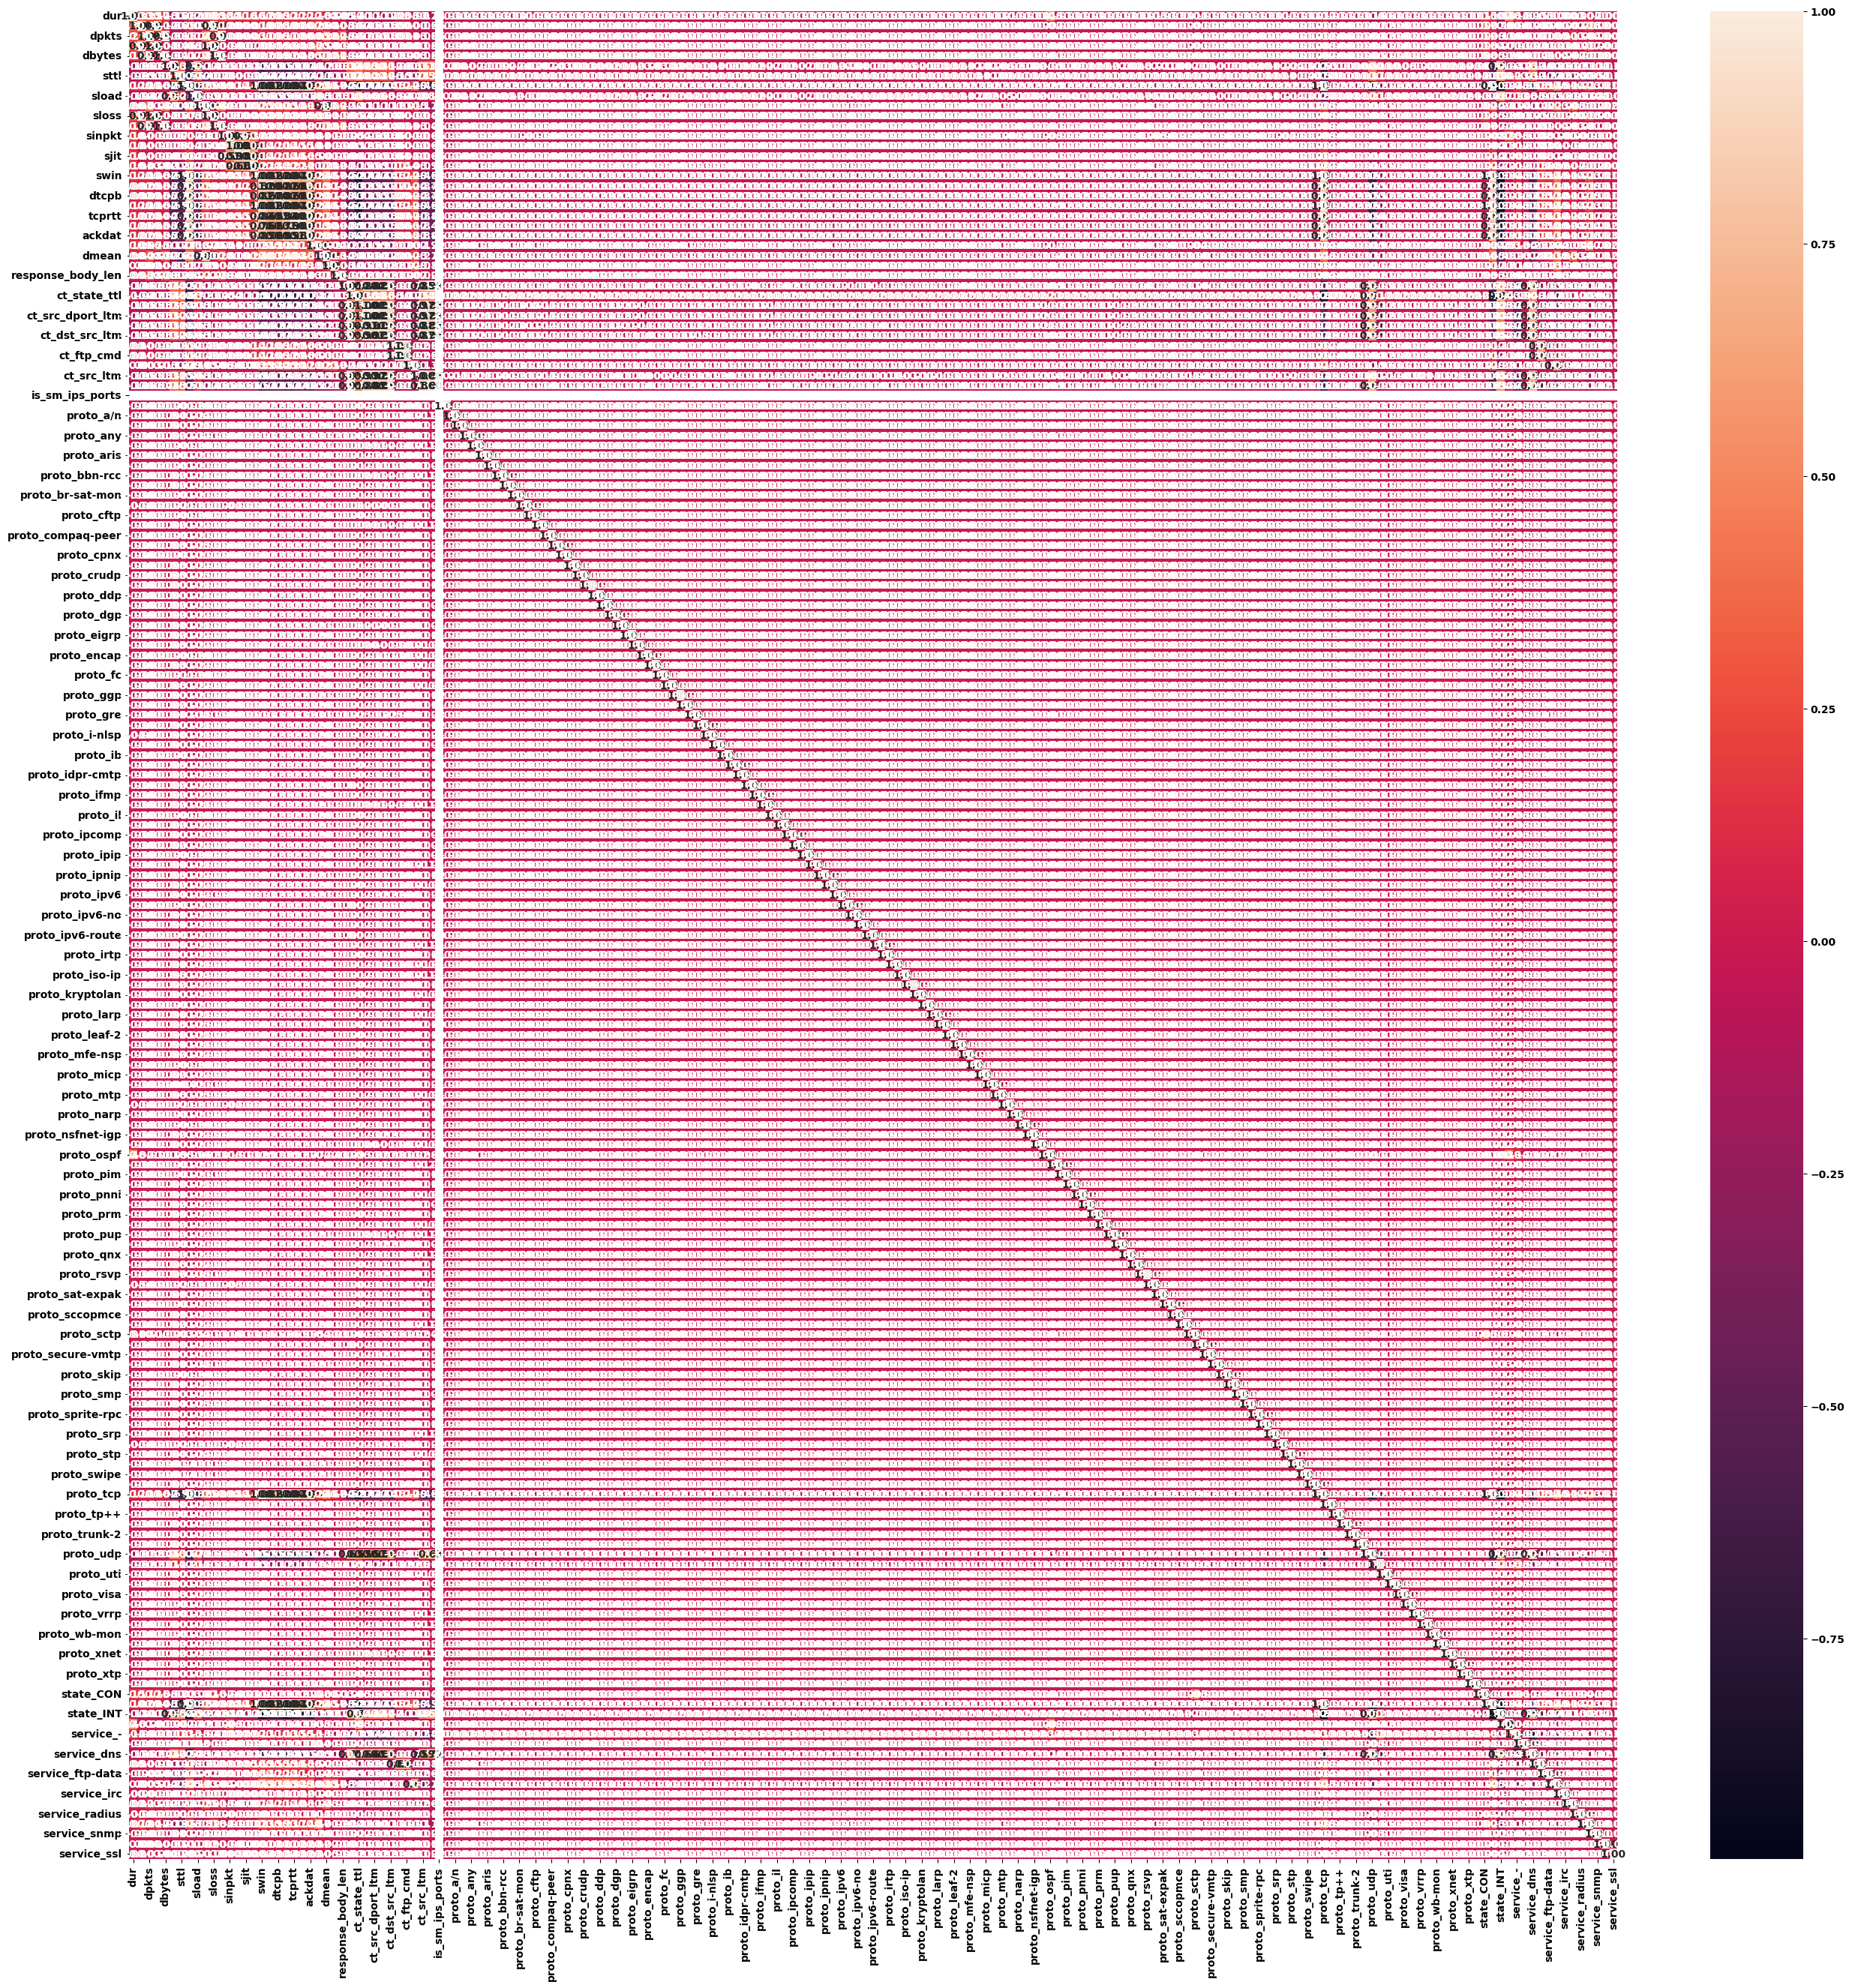

In [51]:
#Correlation between feature
#%matplotlib inline
plt.figure(figsize=[32,32])
sns.heatmap(data_train_attack.corr(), annot=True, fmt=".2f")
plt.show()

In [52]:
#Feature Selection
feature = data_train_attack.drop(['dinpkt', 'ct_ftp_cmd', 'ct_src_dport_ltm', 'is_sm_ips_ports'], axis=1)
feature.dtypes

dur               float64
spkts             float64
dpkts             float64
sbytes            float64
dbytes            float64
                   ...   
service_radius       bool
service_smtp         bool
service_snmp         bool
service_ssh          bool
service_ssl          bool
Length: 181, dtype: object

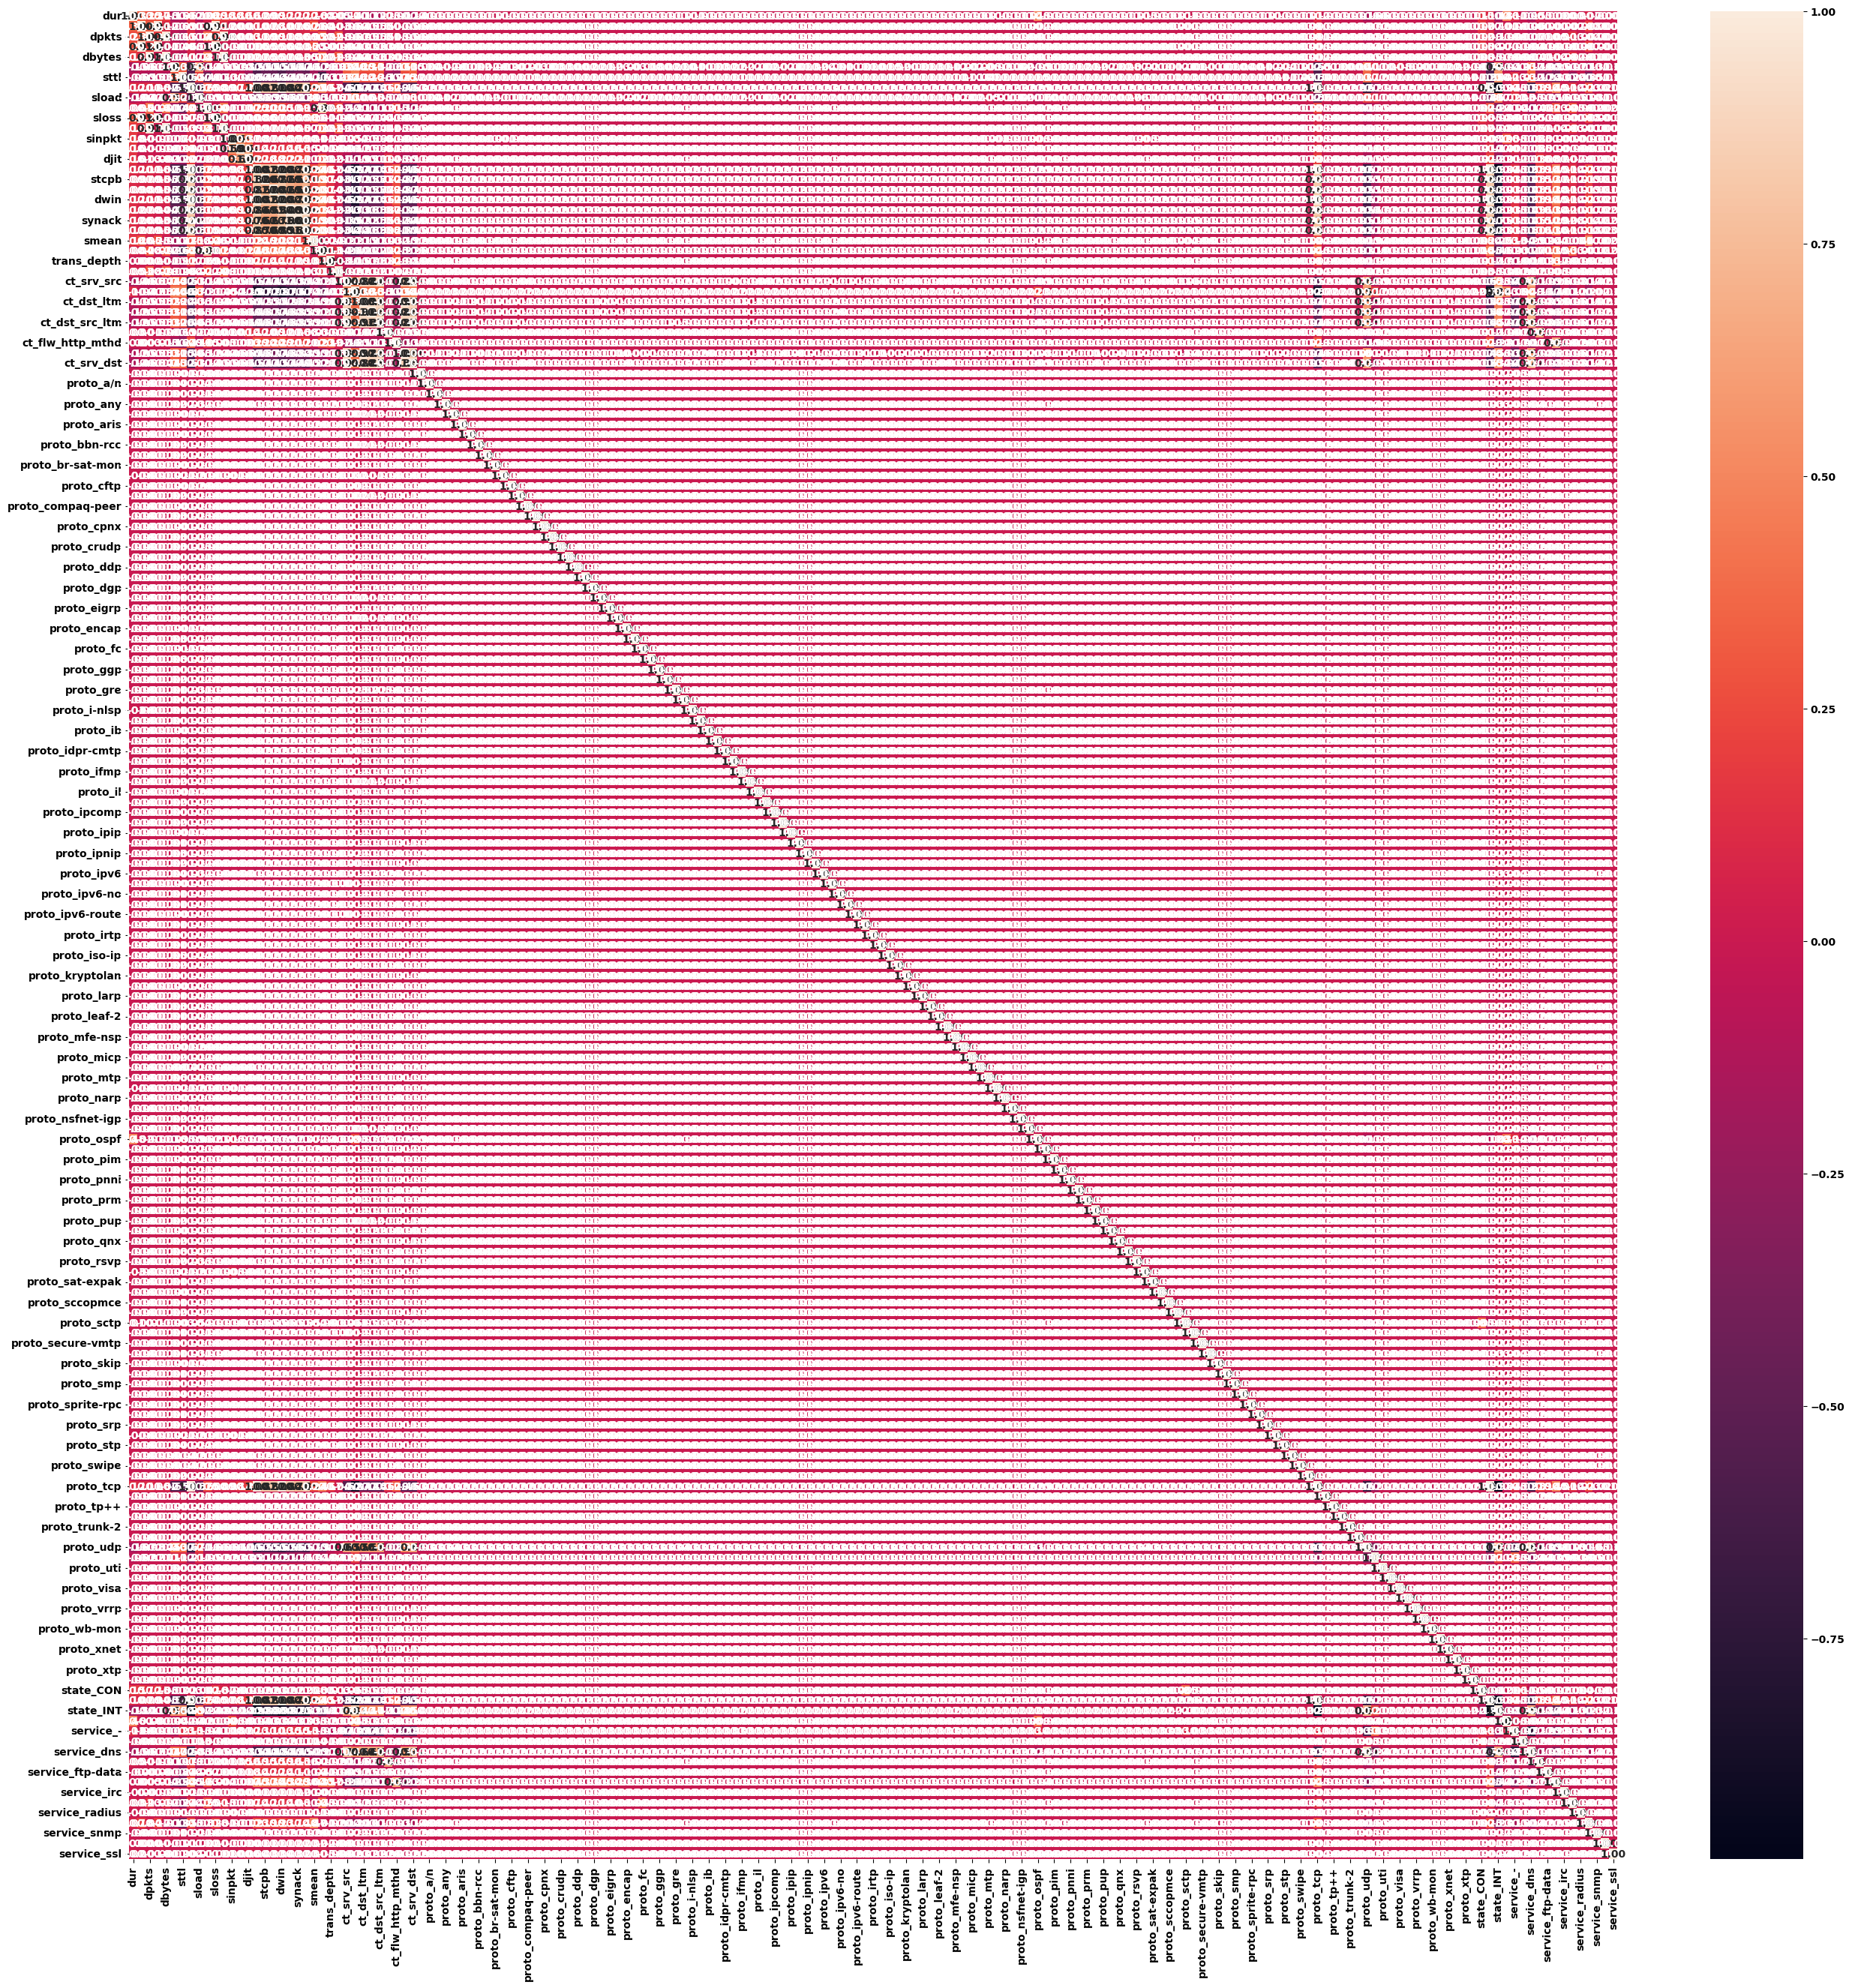

In [53]:
#Correlation between feature
#%matplotlib inline
plt.figure(figsize=[32,32])
sns.heatmap(feature.corr(), annot=True, fmt=".2f")
plt.show()

# Balancing Data

In [54]:
#Splitting the dataset into dependent and independent feature
X_train = feature
y_train = train_attack_cat

X_test = data_test_attack.drop(columns=['dinpkt', 'ct_ftp_cmd', 'ct_src_dport_ltm', 'is_sm_ips_ports'])
y_test = test_attack_cat

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((45329, 181), (45329,), (119329, 181), (119329,))

## SMOTE-Tomek Links

In [55]:
from imblearn.combine import SMOTETomek

stl = SMOTETomek(sampling_strategy='auto')
#stl = SMOTETomek(sampling_strategy=dict({2: 8000, 3: 7800}))
X_stl, y_stl = stl.fit_resample(X_train, y_train)

X_stl.shape, y_stl.shape

((159577, 181), (159577,))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Reconnaissance'),
  Text(1, 0, 'Backdoor'),
  Text(2, 0, 'DoS'),
  Text(3, 0, 'Exploits'),
  Text(4, 0, 'Analysis'),
  Text(5, 0, 'Fuzzers'),
  Text(6, 0, 'Worms'),
  Text(7, 0, 'Shellcode'),
  Text(8, 0, 'Generic')])

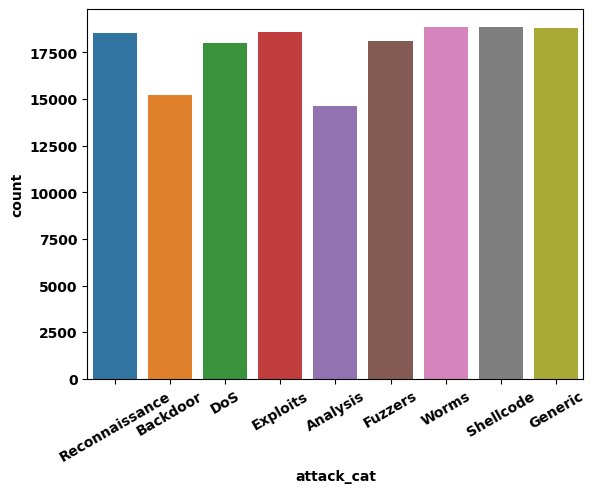

In [56]:
#Create new dataframe from X_stl and y_stl to count every attack
data_stl = pd.concat([X_stl, y_stl], axis=1)

sns.countplot(data=data_stl, x="attack_cat")
plt.xticks(rotation=30)

In [57]:
#data_stl.drop_duplicates(inplace=True)
print(data_stl.value_counts('attack_cat'))
print("--------------------")
print("Shape: " + str(data_stl.shape))
print("--------------------")
print("Duplicates: " + str(data_stl.duplicated().sum()))

attack_cat
Worms             18870
Shellcode         18858
Generic           18805
Exploits          18569
Reconnaissance    18537
Fuzzers           18124
DoS               17988
Backdoor          15202
Analysis          14624
Name: count, dtype: int64
--------------------
Shape: (159577, 182)
--------------------
Duplicates: 46766


# Model Architecture

In [86]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from keras.metrics import Recall, Precision

## CNN Model

In [91]:
# Define the input shape
input_shape = (181, 1)

#Create the sequential model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2)) # reduces the spatial dimensions of the output volume
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(GlobalAveragePooling1D()) # computes the average of all values across the spatial dimensions, effectively flattening the data
model.add(Dropout(0.5)) # helps prevent overfitting by randomly setting a fraction of input units to 0 during training
model.add(Dense(256, activation='relu'))
model.add(Dense(9, activation='softmax'))

#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Recall(), Precision()])

In [92]:
#Print the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 179, 64)           256       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 89, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 87, 128)           24704     
                                                                 
 global_average_pooling1d_6  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 256)              

## Train the model

In [73]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [74]:
le = LabelEncoder()

y_stl = le.fit_transform(y_stl)
y_test = le.fit_transform(y_test)

In [75]:
num_class = 9
y_stl = to_categorical(y_stl, num_class)
y_test = to_categorical(y_test, num_class)

In [63]:
X_stl = np.array(X_stl, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

In [97]:
#Define epochs and batch size
epochs = 50
batch_size = 32

#Train the model
history = model.fit(X_stl, y_stl, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
4987/4987 [==============================] - 61s 12ms/step - loss: 0.6753 - accuracy: 0.7448 - recall_1: 0.6619 - precision_1: 0.8244 - val_loss: 1.0089 - val_accuracy: 0.6464 - val_recall_1: 0.6043 - val_precision_1: 0.7366
Epoch 2/50
4987/4987 [==============================] - 60s 12ms/step - loss: 0.6749 - accuracy: 0.7436 - recall_1: 0.6621 - precision_1: 0.8243 - val_loss: 1.0134 - val_accuracy: 0.6433 - val_recall_1: 0.6023 - val_precision_1: 0.7411
Epoch 3/50
4987/4987 [==============================] - 60s 12ms/step - loss: 0.6739 - accuracy: 0.7443 - recall_1: 0.6634 - precision_1: 0.8256 - val_loss: 0.9642 - val_accuracy: 0.6597 - val_recall_1: 0.6112 - val_precision_1: 0.7535
Epoch 4/50
4987/4987 [==============================] - 61s 12ms/step - loss: 0.6711 - accuracy: 0.7447 - recall_1: 0.6623 - precision_1: 0.8255 - val_loss: 0.9548 - val_accuracy: 0.6612 - val_recall_1: 0.6148 - val_precision_1: 0.7424
Epoch 5/50
4987/4987 [==============================] - 

## Evaluate The Model

In [98]:
#Evaluate the model on test data
loss, accuracy, recall, precision = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
print('Test Recall:', recall)
print('Test Precision:', precision)

3730/3730 [==============================] - 14s 4ms/step - loss: 1.0743 - accuracy: 0.6439 - recall_1: 0.6056 - precision_1: 0.7264
Test Loss: 1.074312448501587
Test Accuracy: 0.6438921093940735
Test Recall: 0.6056113839149475
Test Precision: 0.7263526320457458


### Confusion Matrix